<ipython-input-3-9af935e6097a>:26: RuntimeWarning: invalid value encountered in power
  H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)


[117040.39549999998, 72997.999, 42772.933000000005, 42772.933000000005, 16631.888499999997, 8441.7995, 5862.4175, 5300.2445, 4693.9794999999995, 4049.134, 3850.7200000000003, 3646.7945, 3630.26]


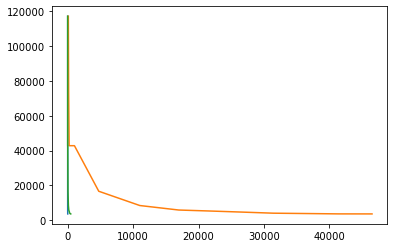

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
import pandas as pd

L_H=[(0.1,100,1),(0.5,150,1.5),(1,225,2.25),(1,1034,10.34),(2,4750,47.5),(3,11023,110.23),(4,16971,169.71),(5,21692,216.92),(6,26509,265.09),(7,31408,314.08),(8,36377,363.77),(9,41409,414.09),(10,46498,464.98)] #h_d;C_i;C_m
L_S=[(-100,-0.1,0,0),(-0.1,0,0,0.1),(0,0.5,150,0.5),(0.5,1,1500,1),(1,1.5,2000,1),(1.5,100,2000,1)]# S_min;S_max;C_s;C_g-percentage
# Constants
L = 5000    # Length of section (m)
B = 300     # Watercourse width (m)
Zb = 55.5  # Shoreline elevation (m NGF)

# Simulation parameters 
vec_size = 100000                # Points to generate

mode_Q, scale_Q = 1013, 558 # Q law (Gumbel)
exp_K, std_K = 30, 7.5      # Ks law (Gaussian)
exp_Zv, hr_Zv = 50, 1       # Zv law (Triangular)
exp_Zm, hr_Zm = 55, 1       # Zm law (Triangular)

# Generate random variables vectors
Q_vec = stat.gumbel_r.rvs(loc=mode_Q, scale=scale_Q, size=vec_size)
Ks_vec = stat.norm.rvs(loc=exp_K, scale=std_K, size=vec_size)
Zv_vec = stat.triang.rvs(c=1/2, loc=exp_Zv-hr_Zv, scale=2*hr_Zv, size=vec_size)
Zm_vec = stat.triang.rvs(c=1/2, loc=exp_Zm-hr_Zm, scale=2*hr_Zm, size=vec_size)
H_vec = (Q_vec/(Ks_vec*B*np.sqrt((Zm_vec-Zv_vec)/L)))**(3/5)
S = Zv_vec + H_vec - Zb

L_C=[]

for i in range(len(L_H)):
    S1=S-L_H[i][0]
    Sc=[0,0,0,0,0,0]
    for j in range(len(S1)):
        for k in range(len(L_S)):
            if S1[j]<L_S[k][1] and S1[j]>L_S[k][0]:
                Sc[k]+=1
                break
    for i in range(len(Sc)):
        Sc[i]=Sc[i]/vec_size
    C=0
    for j in range(len(L_S)):
        C+=L_S[j][1]+L_H[i][1]*L_S[j][2]*Sc[j]
        C+=(L_H[i][1]+30*L_H[i][2])/30
    L_C+=[C]
print(L_C)

plt.plot(L_H,L_C)